<a href="https://colab.research.google.com/github/isaacfinberg/Stochastic-Optimization/blob/main/StochasticOptimizationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.typing import ArrayLike
from typing import Callable, List, Dict
from abc import ABC
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
class Loss(ABC):

  def __init__(self, optimum: ArrayLike) -> None:
    super().__init__()
    self._optimum = optimum
    self._loss_optimum = self.evaluate_loss(self._optimum)

  def evaluate_loss(self, theta: ArrayLike) -> float:
    pass
  
  def evaluate_gradient(self, theta: ArrayLike) -> ArrayLike:
    pass

  @property
  def optimum(self) -> ArrayLike:
    return self._optimum

  @property
  def loss_optimum(self) -> float:
    return self._loss_optimum

class Gain(ABC):

  def __init__(self, gain_coeff: float) -> None:
    super().__init__()
    self._gain_coeff = gain_coeff

  def compute_gain(self, k: int, *args) -> float:
    pass
  
class Constraint(ABC):

  def __init__(self) -> None:
    super().__init__()

  def constrain(self, *args) -> ArrayLike:
    pass

class Optimizer(ABC):

  def __init__(self, theta_0: ArrayLike, loss: Loss, gradient_gain: Gain, constraint: Constraint) -> None:
    super().__init__()
    self._theta_0 = theta_0
    self._theta = theta_0.copy()
    self._loss = loss
    self._loss_0 = self._loss.evaluate_loss(self._theta_0)
    self._gradient_gain = gradient_gain
    self._constraint = constraint
    self._mean_terminal_theta: float = None
    self._mean_normalized_error_theta: ArrayLike = None
    self._mean_normalized_error_loss: ArrayLike = None
    self._mean_loss_values: ArrayLike = None

  def _update(self, k: int) -> None:
    pass

  def _inject_gaussian_noise(self, gradient: ArrayLike, mean: float = 0., sd: float = 1.) -> ArrayLike:
    return gradient + np.random.normal(mean, sd, size=len(gradient))

  def _compute_normalized_errors(self) -> Dict[str, float]:
    normalized_error_theta = np.linalg.norm(self._theta - self._loss.optimum) / np.linalg.norm(self._loss.optimum - self._theta_0)
    normalized_error_loss = np.abs(self._loss.evaluate_loss(self._theta) - self._loss.loss_optimum) / np.abs(self._loss.loss_optimum - self._loss_0)
    return {'theta': normalized_error_theta, 'loss': normalized_error_loss}

  def optimize(self) -> None:
    pass
  
  def plot_loss_curve(self) -> None:
    plt.plot(self._mean_loss_values, '-')
    plt.title('Loss Curve')
    plt.xlabel('k')
    plt.ylabel('Loss Value')

  @property
  def mean_terminal_theta(self) -> ArrayLike:
    return self._mean_terminal_theta

  @property
  def mean_loss_values(self) -> ArrayLike:
    return self._mean_loss_values

  @property
  def mean_normalized_error_theta(self) -> ArrayLike:
    return self._mean_normalized_error_theta

  @property
  def mean_normalized_error_loss(self) -> ArrayLike:
    return self._mean_normalized_error_loss

In [ ]:
class BoundaryConstraint(Constraint):

  def __init__(self, bounds: List[float]) -> None:
    super().__init__()
    self._bounds = bounds

  def constrain(self, theta: ArrayLike) -> ArrayLike:
    upper_bound = self._bounds[1]
    lower_bound = self._bounds[0]
    theta[theta > upper_bound] = upper_bound
    theta[theta < lower_bound] = lower_bound
    return theta

class IdentityContstraint(Constraint):

  def constrain(self, theta: ArrayLike) -> ArrayLike:
    return theta

In [ ]:
class GradientGainA(Gain):

  def compute_gain(self, k: int) -> float:
    return self._gain_coeff / np.log(k + 1 + 1)

class GradientGainBCD(Gain):

  def __init__(self, gain_coeff: float, gain_exp_coeff: float, A: float) -> None:
    super().__init__(gain_coeff)
    self._gain_exp_coeff = gain_exp_coeff
    self._A = A

  def compute_gain(self, k: int) -> float:
    return self._gain_coeff / (self._A + k + 1)**self._gain_exp_coeff

class AnnealingGainB(Gain):

  def compute_gain(self, k: int) -> float:
    return self._gain_coeff / np.sqrt((k + 1) * np.log(np.log(k + 1)))

class AnnealingGainC(Gain):

  def __init__(self, gain_coeff: float, gain_exp_coeff: float) -> None:
    super().__init__(gain_coeff)
    self._gain_exp_coeff = gain_exp_coeff

  def compute_gain(self, k: int) -> float:
    return self._gain_coeff / ((k+1)**(self._gain_exp_coeff / 2) * np.log(k + 1))

class AnnealingGainD(Gain):

  def __init__(self, gain_coeff: float, gain_exp_coeff: float, gain_coeff_extra: float) -> None:
    super().__init__(gain_coeff)
    self._gain_exp_coeff = gain_exp_coeff
    self._gain_coeff_extra = gain_coeff_extra

  def compute_gain(self, k: int) -> float:
    return self._gain_coeff / np.sqrt((k + 1)**self._gain_exp_coeff * np.log((k + 1)**(1 - self._gain_exp_coeff) + self._gain_coeff_extra))

In [ ]:
class QuadraticPlusMultiplicativeCosine(Loss):

  def __init__(self, optimum: ArrayLike) -> None:
    super().__init__(optimum)

  def evaluate_loss(self, theta: ArrayLike) -> float:
    return 0.05 * np.sum(theta**2) - 40 * np.prod(np.cos(theta))

  def evaluate_gradient(self, theta: ArrayLike) -> ArrayLike:
    dim = len(theta)
    indeces = range(dim)
    trig_coeff = np.array(
        [
            np.prod(
                np.cos(
                    theta[~np.isin(i, indeces)]
                    )
                ) 
            for i in indeces
        ]
    )
    return 0.1 * theta + 40 * trig_coeff * np.sin(theta)

class DropWave(Loss):

  def __init__(self, optimum: ArrayLike) -> None:
    super().__init__(optimum)

  def evaluate_loss(self, theta: ArrayLike) -> float:
    x1 = theta[0]
    x2 = theta[1]
    numerator = -1 - (np.cos(12 * np.sqrt(x1**2 + x2**2)))
    denominator = 0.5 * (x1**2 + x2**2) + 2
    return 1 - (numerator / denominator) 

  def evaluate_gradient(self, theta: ArrayLike) -> ArrayLike:
    return np.array([self._evaluate_partial(theta)] * len(theta))

  def _evaluate_partial(self, theta: ArrayLike) -> ArrayLike:
    x1 = theta[0]
    x2 = theta[1]
    numerator = -((6 * np.sin(12 * np.sqrt(x1 + x2))*(0.5 * (x1 + x2) + 2)) / np.sqrt(x1 + x2)) - (0.5 * np.cos(12 * np.sqrt(x1 + x2)))
    denominator = (0.5 * (x1 + x2) + 2)**2
    return numerator / denominator

class Ackley(Loss):

  def __init__(self, optimum: ArrayLike) -> None:
    super().__init__(optimum)

  def evaluate_loss(self, theta: ArrayLike) -> float:
    n = len(theta)
    sum_sq = np.sum(theta**2)
    sum_cos = np.sum(np.cos(2 * np.pi * theta))
    return -20 * np.exp(-0.2 * np.sqrt(sum_sq / n)) - np.exp(sum_cos / n) + np.e + 20

  def evaluate_gradient(self, theta: ArrayLike) -> ArrayLike:
    n = len(theta)
    sum_sq = np.sum(theta**2)
    sum_cos = np.sum(np.cos(2 * np.pi * theta))
    exp_cos = np.exp(sum_cos / n)
    gradient = np.zeros_like(theta)
    for i in range(n):
        gradient[i] = (2 * theta[i] / n) * np.exp(-0.2 * np.sqrt(sum_sq / n)) + (2 * np.pi / n) * np.sin(2 * np.pi * theta[i]) * exp_cos
    return gradient

In [ ]:
class SG(Optimizer):

  def __init__(self, theta_0: ArrayLike, loss: Loss, gradient_gain: Gain, constraint: Constraint = IdentityContstraint()) -> None:
    super().__init__(theta_0, loss, gradient_gain, constraint)

  def _update(self, k) -> None:
    gradient = self._loss.evaluate_gradient(self._theta)
    gradient_gain = self._gradient_gain.compute_gain(k)
    self._theta -= gradient_gain * self._inject_gaussian_noise(gradient)
    self._theta = self._constraint.constrain(self._theta)

  def optimize(self, iterations: int, replications: int = 1) -> None:
    replicate_thetas, replicate_loss_values = [], []
    normalized_error_thetas, normalized_error_losses = [], []
    for _ in range(replications):
      self._theta = self._theta_0.copy()
      loss_values = []
      for k in range(iterations):
        self._update(k)
        loss_values.append(self._loss.evaluate_loss(self._theta))
      replicate_thetas.append(self._theta)
      replicate_loss_values.append(loss_values)
      errors = self._compute_normalized_errors()
      normalized_error_losses.append(errors['loss'])
      normalized_error_thetas.append(errors['theta'])
    self._mean_normalized_error_loss = np.mean(normalized_error_losses)
    self._mean_normalized_error_theta = np.mean(normalized_error_thetas)
    self._mean_loss_values = np.mean(replicate_loss_values, axis=0)
    self._mean_terminal_theta = np.mean(replicate_thetas, axis=0)

class SGA(SG):

  def __init__(self, theta_0: ArrayLike, loss: Loss, gradient_gain: Gain, annealing_gain: Gain, annealing_sd: float, constraint: Constraint = IdentityContstraint()) -> None:
    super().__init__(theta_0, loss, gradient_gain, constraint)
    self._annealing_gain = annealing_gain
    self._annealing_sd = annealing_sd

  def _update(self, k: int) -> None:
    gradient = self._loss.evaluate_gradient(self._theta)
    gradient_gain = self._gradient_gain.compute_gain(k)
    annealing_gain = self._annealing_gain.compute_gain(k)
    self._theta -= gradient_gain * self._inject_gaussian_noise(gradient) + annealing_gain * self._inject_gaussian_noise(np.zeros_like(gradient), sd=self._annealing_sd)
    self._theta = self._constraint.constrain(self._theta)

class SGM(SG):
  
  def __init__(self, theta_0: ArrayLike, loss: Loss, gradient_gain: Gain, momentum_gain: Gain, constraint: Constraint = IdentityContstraint()) -> None:
    super().__init__(theta_0, loss, gradient_gain, constraint)
    self._momentum_gain = momentum_gain

  def _update(self, k: int) -> None:
    momentum_gain = self._momentum_gain.compute_gain(k)
    momentum_gradient = (1 - momentum_gain) * self._inject_gaussian_noise(self._loss.evaluate_gradient(self._theta)) + momentum_gain * self._previous_gradient
    gradient_gain = self._gradient_gain.compute_gain(k)
    self._theta -= gradient_gain * momentum_gradient
    self._theta = self._constraint.constrain(self._theta)
    self._previous_gradient = momentum_gradient

  def optimize(self, iterations: int, replications: int = 1) -> None:
    replicate_thetas, replicate_loss_values = [], []
    normalized_error_thetas, normalized_error_losses = [], []
    for _ in range(replications):
      self._theta = self._theta_0.copy()
      self._previous_gradient = self._inject_gaussian_noise(self._loss.evaluate_gradient(self._theta))
      loss_values = []
      for k in range(iterations):
        self._update(k)
        loss_values.append(self._loss.evaluate_loss(self._theta))
      replicate_thetas.append(self._theta)
      replicate_loss_values.append(loss_values)
      errors = self._compute_normalized_errors()
      normalized_error_losses.append(errors['loss'])
      normalized_error_thetas.append(errors['theta'])
    self._mean_normalized_error_loss = np.mean(normalized_error_losses)
    self._mean_normalized_error_theta = np.mean(normalized_error_thetas)
    self._mean_loss_values = np.mean(replicate_loss_values, axis=0)
    self._mean_terminal_theta = np.mean(replicate_thetas, axis=0)

class SGAM(SG):
  
  optimize = SGM.__dict__['optimize']

  def __init__(self, theta_0: ArrayLike, loss: Loss, gradient_gain: Gain, annealing_gain: Gain, momentum_gain: Gain, annealing_sd: float, constraint: Constraint = IdentityContstraint()) -> None:
    super().__init__(theta_0, loss, gradient_gain, constraint)
    self._momentum_gain = momentum_gain
    self._annealing_gain = annealing_gain
    self._annealing_sd = annealing_sd

  def _update(self, k) -> None:
    momentum_gain = self._momentum_gain.compute_gain(k)
    momentum_gradient = (1 - momentum_gain) * self._loss.evaluate_gradient(self._theta) + momentum_gain * self._previous_gradient
    gradient_gain = self._gradient_gain.compute_gain(k)
    annealing_gain = self._annealing_gain.compute_gain(k)
    noisy_gradient = self._inject_gaussian_noise(momentum_gradient)
    self._theta -= gradient_gain * noisy_gradient + annealing_gain * self._inject_gaussian_noise(np.zeros_like(momentum_gradient), sd=self._annealing_sd)
    self._theta = self._constraint.constrain(self._theta)
    self._previous_gradient = momentum_gradient

terminal loss: -20.309353320394543
terminal theta: [6.26658982 6.26981319 6.2674589  6.26636746 6.2680403  6.26786631
 6.26746343 6.26745677 6.26815522 6.26836027]
normalized error theta: 1.0000251134321825
normalized error loss: 1.0000349906227486


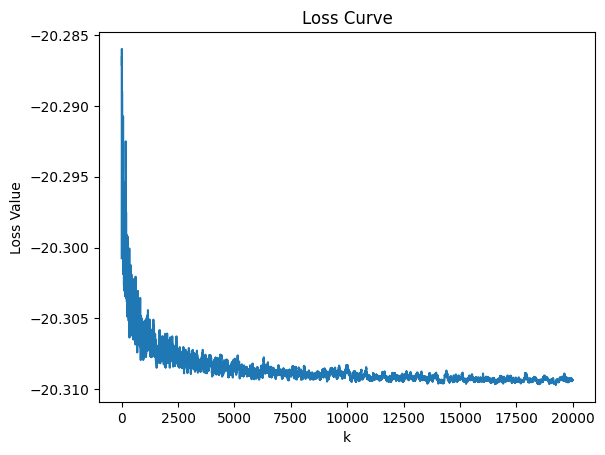

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 0.1
A = 100
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
loss = QuadraticPlusMultiplicativeCosine(optimum)
optimizer = SG(theta_0, loss, gradient_gain)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: -25.345507466121667
terminal theta: [-1.42429772  1.30544667  0.0871272   0.12440951 -0.01078097 -0.09390522
  0.03159404 -2.64857664 -1.34177238  1.28661044]
normalized error theta: 0.4431405689731728
normalized error loss: 0.7442622653362141


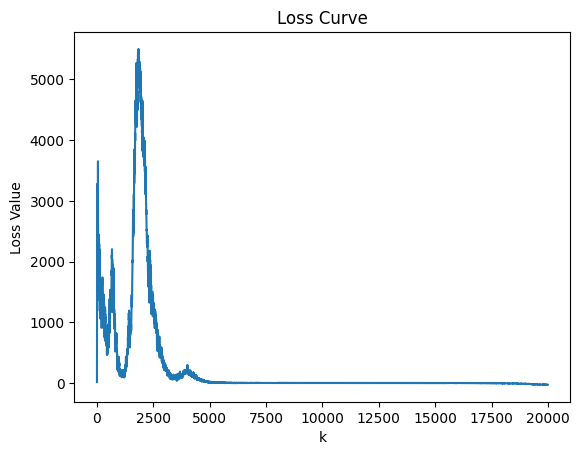

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
momentum_gain_coeff = 0.1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
momentum_gain = GradientGainA(momentum_gain_coeff)
loss = QuadraticPlusMultiplicativeCosine(optimum)
optimizer = SGM(theta_0, loss, gradient_gain, momentum_gain)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: -12.104026044301282
terminal theta: [-2.64091834 -1.37341425  2.23122475  1.0870239  -0.08268774  1.0692392
  0.05043748 -2.24637047 -0.05876404  2.42809549]
normalized error theta: 0.5089833120176736
normalized error loss: 1.4167614963145834


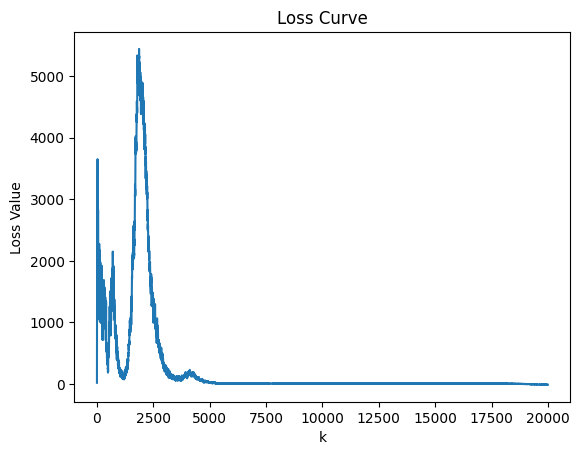

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
annealing_gain_coeff = 0.5
annealing_sd = 1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 
annealing_gain_coeff_extra = 10

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
annealing_gain = AnnealingGainD(annealing_gain_coeff, gain_exp_coeff, annealing_gain_coeff_extra)
loss = QuadraticPlusMultiplicativeCosine(optimum)
optimizer = SGA(theta_0, loss, gradient_gain, annealing_gain, annealing_sd)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: -26.330514037511826
terminal theta: [-2.33758992 -1.21860312  1.22526298 -2.43896364 -1.13162492  0.14087604
 -0.00445944 -0.00507352 -1.40774591 -1.39366395]
normalized error theta: 0.46081359499948027
normalized error loss: 0.6942364305623995


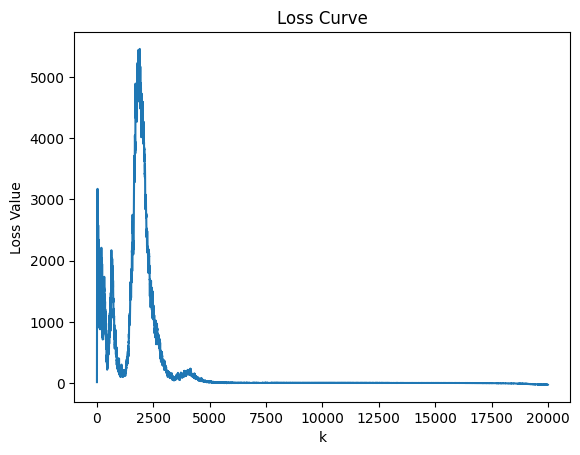

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
annealing_gain_coeff = 0.5
momentum_gain_coeff = 0.1
annealing_sd = 1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 
annealing_gain_coeff_extra = 10

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
annealing_gain = AnnealingGainD(annealing_gain_coeff, gain_exp_coeff, annealing_gain_coeff_extra)
momentum_gain = GradientGainA(momentum_gain_coeff)
loss = QuadraticPlusMultiplicativeCosine(optimum)
optimizer = SGAM(theta_0, loss, gradient_gain, annealing_gain, momentum_gain, annealing_sd)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: 13.998753346103532
terminal theta: [5.9631771  5.96489521 5.96618371 5.96741804 5.96475993 5.96522629
 5.96607858 5.96253269 5.96439268 5.96608429]
normalized error theta: 0.9517320102276946
normalized error loss: 0.8687966541787011


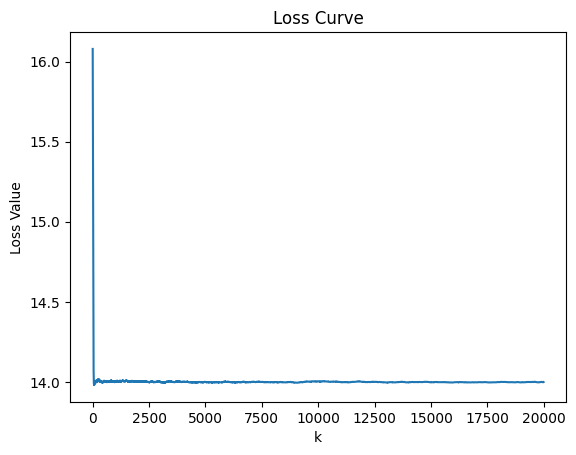

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 0.1
A = 100
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
loss = Ackley(optimum)
optimizer = SG(theta_0, loss, gradient_gain)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: 2.175138739338653
terminal theta: [ 0.00982299 -0.25595419 -0.22896109 -0.18807572 -0.22571088  0.03379087
  0.36329589  0.17934372 -0.22464986  0.02113526]
normalized error theta: 0.08445221572732821
normalized error loss: 0.13499439645730318


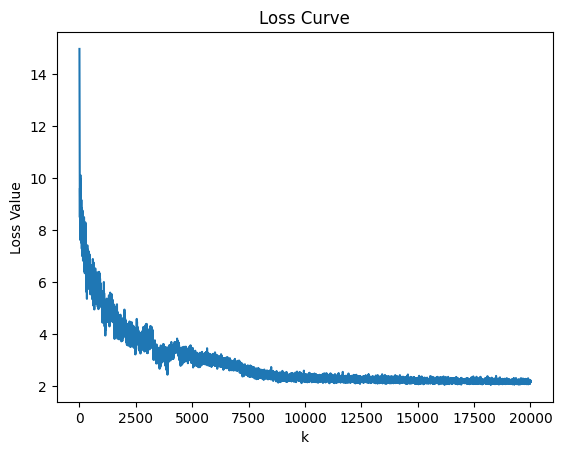

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
momentum_gain_coeff = 0.1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
momentum_gain = GradientGainA(momentum_gain_coeff)
loss = Ackley(optimum)
optimizer = SGM(theta_0, loss, gradient_gain, momentum_gain)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: 2.602723339354436
terminal theta: [-0.01221263 -0.38989848 -0.39447111  0.2250626  -0.60303684 -0.01323993
 -0.38798398 -0.16819944  0.20420652  0.22280738]
normalized error theta: 0.10283537461296566
normalized error loss: 0.16153133590380397


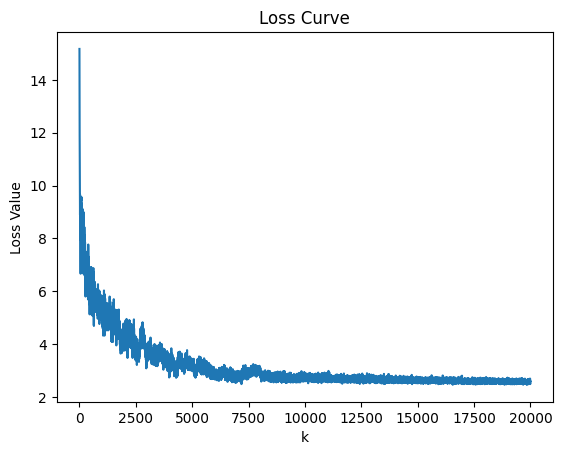

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
annealing_gain_coeff = 0.5
annealing_sd = 1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 
annealing_gain_coeff_extra = 10

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
annealing_gain = AnnealingGainD(annealing_gain_coeff, gain_exp_coeff, annealing_gain_coeff_extra)
loss = Ackley(optimum)
optimizer = SGA(theta_0, loss, gradient_gain, annealing_gain, annealing_sd)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

terminal loss: 2.472144086077482
terminal theta: [ 0.40757241  0.39448827 -0.00412174  0.18620262  0.194764    0.36550178
 -0.01117168 -0.02439361 -0.03438286  0.03929402]
normalized error theta: 0.09654066523268783
normalized error loss: 0.15342727009541912


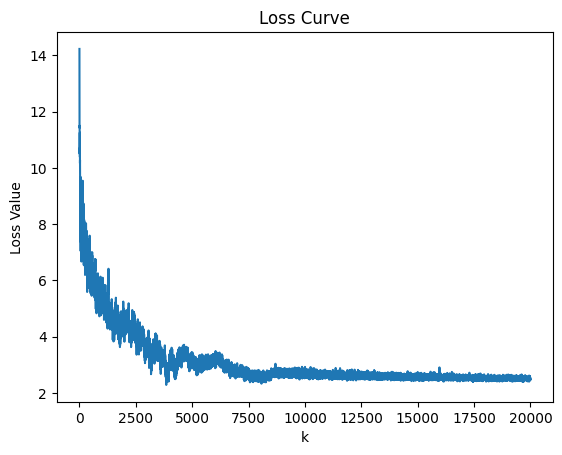

In [ ]:
iterations = 20000
replications = 5
gradient_gain_coeff = 20
A = 100
annealing_gain_coeff = 0.5
momentum_gain_coeff = 0.1
annealing_sd = 1
p = 10
theta_0 = np.ones([p]) * 6.2676
optimum = np.zeros_like(theta_0)
gain_exp_coeff = 0.602 
annealing_gain_coeff_extra = 10

gradient_gain = GradientGainBCD(gradient_gain_coeff, gain_exp_coeff, A)
annealing_gain = AnnealingGainD(annealing_gain_coeff, gain_exp_coeff, annealing_gain_coeff_extra)
momentum_gain = GradientGainA(momentum_gain_coeff)
loss = Ackley(optimum)
optimizer = SGAM(theta_0, loss, gradient_gain, annealing_gain, momentum_gain, annealing_sd)
optimizer.optimize(iterations, replications)
optimizer.plot_loss_curve()
print('terminal loss:', optimizer.mean_loss_values[-1])
print('terminal theta:', optimizer.mean_terminal_theta)
print('normalized error theta:', optimizer.mean_normalized_error_theta)
print('normalized error loss:', optimizer.mean_normalized_error_loss)

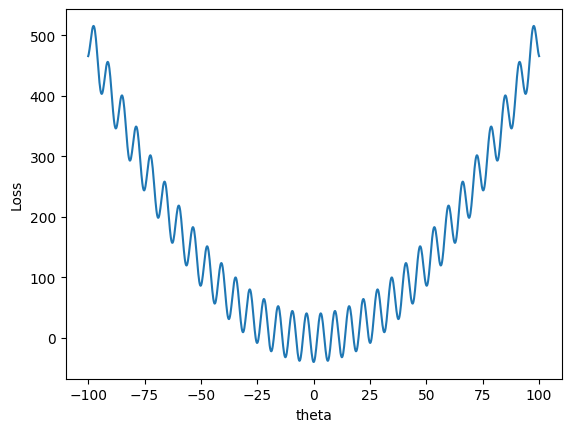

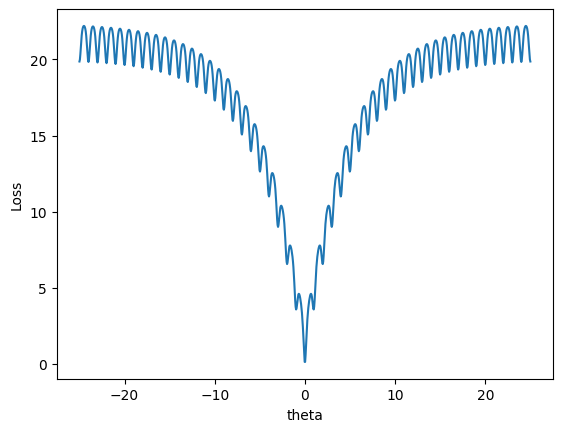

In [ ]:
l = QuadraticPlusMultiplicativeCosine(optimum)
plt.figure()
plt.plot(np.linspace(-100, 100, 1000), [l.evaluate_loss(np.array([i])) for i in np.linspace(-100, 100, 1000)])
plt.xlabel('theta')
plt.ylabel('Loss');

l = Ackley(optimum)
plt.figure()
plt.plot(np.linspace(-25, 25, 1000), [l.evaluate_loss(np.array([i])) for i in np.linspace(-25, 25, 1000)])
plt.xlabel('theta')
plt.ylabel('Loss');

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class SGAM(optim.SGD):
    def __init__(self, params, annealing_gain, lr=0.01, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        super(SGAM, self).__init__(params, lr, momentum, dampening,
                                             weight_decay, nesterov)
        self._annealing_gain = annealing_gain

    def step(self, k, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            momentum = group['momentum']
            weight_decay = group['weight_decay']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                # Add scaled noise to the gradient
                noise = torch.randn_like(p.grad.data)
                gain = self._annealing_gain.compute_gain(k)
                noise.mul_(gain)
                d_p.add_(noise)

                p.data.add_(-group['lr'], d_p)

        return loss

# Define the neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(in_features=7*7*64, out_features=1024)
        self.relu3 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Load the MNIST dataset and transform the images to tensors
train_dataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

# Create data loaders to load the data in batches during training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Create an instance of the neural network model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
gain_exp_coeff = 0.602 
annealing_gain_coeff = 1
annealing_gain_coeff_extra = 10
annealing_gain = AnnealingGainD(annealing_gain_coeff, gain_exp_coeff, annealing_gain_coeff_extra)
# annealing_gain = GradientGainA(annealing_gain_coeff)
# optimizer = SGAM(model.parameters(), annealing_gain, lr=0.01, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
k = 0
loss_values = []
for epoch in range(5):  # Train for 5 epochs
    for batch_idx, (data, targets) in enumerate(train_loader):

      data, targets = data.to(device), targets.to(device)
      # Clear the gradients
      optimizer.zero_grad()

      # Forward pass
      predictions = model(data)
      loss = criterion(predictions, targets)

      # Backward pass
      loss.backward()
      loss_values.append(loss.item())
      optimizer.step()
      k += 1

      # Print the training progress
      if batch_idx % 100 == 0:
          print(f"Epoch {epoch+1}/{5} Batch {batch_idx}/{len(train_loader)} Loss {loss.item():.4f}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
      data, targets = data.to(device), targets.to(device)
      predictions = model(data)
      _, predicted_labels = torch.max(predictions.data, 1)
      total += targets.size(0)
      correct += (predicted_labels == targets).sum().item()

    print(f"Accuracy on the test set: {100 * correct / total:.2f}%")


Epoch 1/5 Batch 0/938 Loss 2.3011
Epoch 1/5 Batch 100/938 Loss 2.2452
Epoch 1/5 Batch 200/938 Loss 2.0631
Epoch 1/5 Batch 300/938 Loss 1.0797
Epoch 1/5 Batch 400/938 Loss 0.7033
Epoch 1/5 Batch 500/938 Loss 0.4718
Epoch 1/5 Batch 600/938 Loss 0.4792
Epoch 1/5 Batch 700/938 Loss 0.2345
Epoch 1/5 Batch 800/938 Loss 0.4291
Epoch 1/5 Batch 900/938 Loss 0.3140
Epoch 2/5 Batch 0/938 Loss 0.2068
Epoch 2/5 Batch 100/938 Loss 0.2344
Epoch 2/5 Batch 200/938 Loss 0.3960
Epoch 2/5 Batch 300/938 Loss 0.2486
Epoch 2/5 Batch 400/938 Loss 0.1413
Epoch 2/5 Batch 500/938 Loss 0.1831
Epoch 2/5 Batch 600/938 Loss 0.4472
Epoch 2/5 Batch 700/938 Loss 0.1306
Epoch 2/5 Batch 800/938 Loss 0.2952
Epoch 2/5 Batch 900/938 Loss 0.1690
Epoch 3/5 Batch 0/938 Loss 0.0652
Epoch 3/5 Batch 100/938 Loss 0.0713
Epoch 3/5 Batch 200/938 Loss 0.1757
Epoch 3/5 Batch 300/938 Loss 0.0810
Epoch 3/5 Batch 400/938 Loss 0.2337
Epoch 3/5 Batch 500/938 Loss 0.2083
Epoch 3/5 Batch 600/938 Loss 0.1035
Epoch 3/5 Batch 700/938 Loss 0.098

sgdm: Accuracy on the test set: 97.74% \\
sgd: Accuracy on the test set: 87.54% \\
sgdam: Accuracy on the test set: 98.01% \\
sgda: Accuracy on the test set: 87.99%

Text(0.5, 1.0, 'Loss Curve')

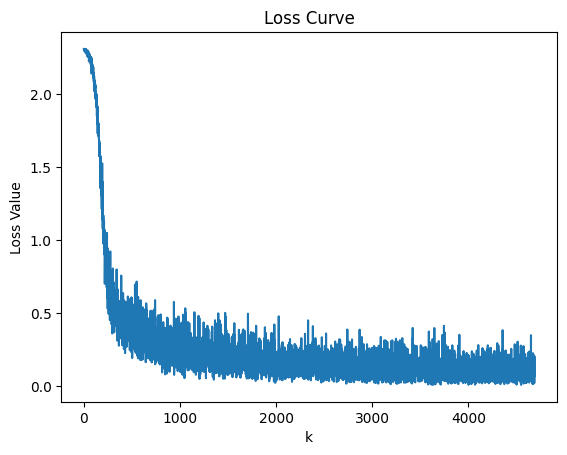

In [ ]:
# sgdam
plt.plot(loss_values)
plt.xlabel('k')
plt.ylabel('Loss Value')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Loss Curve')

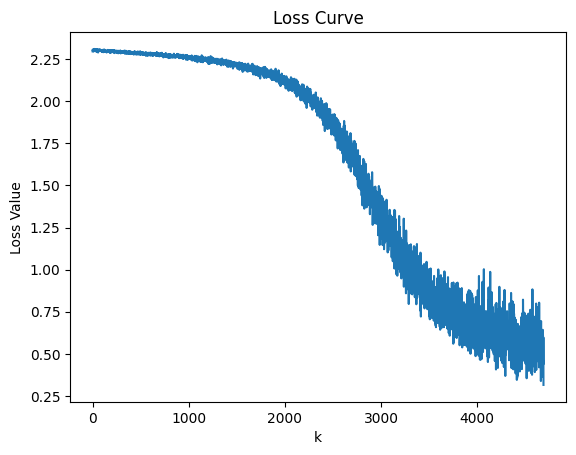

In [ ]:
# sga
plt.plot(loss_values)
plt.xlabel('k')
plt.ylabel('Loss Value')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Loss Curve')

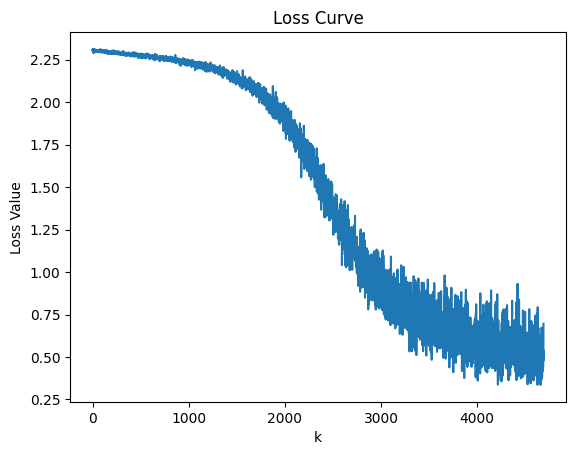

In [ ]:
#sgd
plt.plot(loss_values)
plt.xlabel('k')
plt.ylabel('Loss Value')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Loss Curve')

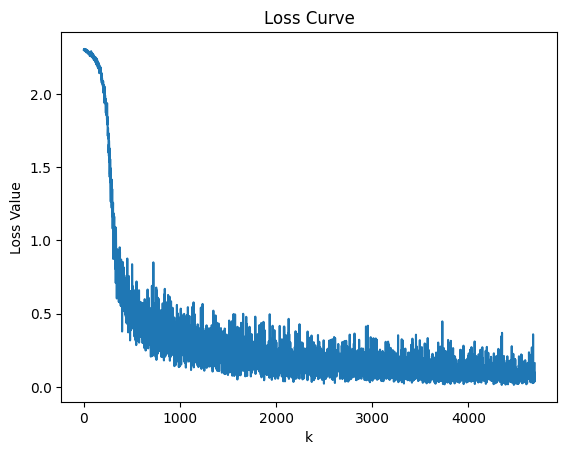

In [ ]:
# sgdm
plt.plot(loss_values)
plt.xlabel('k')
plt.ylabel('Loss Value')
plt.title('Loss Curve')

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

3274634